In [1]:
% pylab inline
import tensorflow as tf
import numpy as np
# import matplotlib.pyplot as plt
from tqdm import tqdm
from tensorflow.contrib.kfac.python.ops.utils import fwd_gradients
import seaborn as sns
from utils import get_getter
from universal_divergence import estimate
from utils import nn_l2_mean


slim = tf.contrib.slim
ds = tf.contrib.distributions
import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"


Populating the interactive namespace from numpy and matplotlib


In [2]:
tf.reset_default_graph()



### Generator and discriminator architectures

(same architecture as proposed in google brain paper)


In [3]:
def generator(z, output_dim=2, n_hidden=384, n_layer=6, getter=None, reuse=False):
    with tf.variable_scope("generator", custom_getter=getter, reuse=reuse):
        h = slim.stack(z, slim.fully_connected, [n_hidden] * n_layer, activation_fn=tf.nn.relu)
        x = slim.fully_connected(h, output_dim, activation_fn=None)
    return x

def discriminator(x, n_hidden=384, n_layer=6, reuse=False, getter=None):
    with tf.variable_scope("discriminator", reuse=reuse,custom_getter=getter):
        h = slim.stack(x, slim.fully_connected, [n_hidden] * n_layer, activation_fn=tf.nn.relu)
        log_d = slim.fully_connected(h, 1, activation_fn=None)
    return log_d

### Data creation

In [4]:
def sample_mog(batch_size, n_mixture=16, std=0.2):
    x = np.linspace(-4.5,4.5,4)
    xs, ys = np.meshgrid(x, x)
    xs, ys = xs.flatten(), ys.flatten()
    cat = ds.Categorical(tf.zeros(n_mixture))
    comps = [ds.MultivariateNormalDiag([xi, yi], [std, std]) for xi, yi in zip(xs.ravel(), ys.ravel())]
    data = ds.Mixture(cat, comps)
    return data.sample(batch_size)

### Hyperparam

In [5]:
params = dict(
    batch_size=512,
    learning_rate=9e-5,
    beta1=0.5,
    epsilon=1e-8,
    max_iter=30000,
    viz_every=3000,
    z_dim=256,
    x_dim=2,
    optimizer='rmsprop', # rmsprop sgd sga
)

## Construct model and training ops

In [12]:
tf.reset_default_graph()

data = sample_mog(params['batch_size'])
noise = ds.Normal(tf.zeros(params['z_dim']), tf.ones(params['z_dim'])).sample(params['batch_size'])


# Construct generator and discriminator nets
with slim.arg_scope([slim.fully_connected], weights_initializer=tf.orthogonal_initializer(gain=1.2)):
    samples = generator(noise, output_dim=params['x_dim'])
    real_score = discriminator(data)
    fake_score = discriminator(samples, reuse=True)
    
gvars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "generator")
dvars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "discriminator")
variables = dvars + gvars
ema_g = tf.train.ExponentialMovingAverage(decay=0.999)
ema_d = tf.train.ExponentialMovingAverage(decay=0.999)

samples_ema = generator(noise, output_dim=params['x_dim'], getter=get_getter(ema_g),reuse=True)
fake_score_ema_g = discriminator(samples_ema, reuse=True)
fake_score_ema_d = discriminator(samples, reuse=True, getter=get_getter(ema_d))

# ema objective
loss_d = tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(logits=real_score, labels=tf.ones_like(real_score))) + tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_score_ema_g, labels=tf.zeros_like(fake_score)))

loss_g = tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_score_ema_d, labels=tf.ones_like(fake_score)))

# optimizer = tf.train.RMSPropOptimizer(learning_rate=params['learning_rate'])
optimizer = tf.train.AdamOptimizer(params['learning_rate'], beta1=params['beta1'], epsilon=params['epsilon'])
d_grads = tf.gradients(loss_d, dvars)
g_grads = tf.gradients(loss_g, gvars)

grads = d_grads + g_grads

# reg = 0.5 * sum(tf.reduce_sum(tf.square(g)) for g in grads)
# Jgrads = tf.gradients(reg, variables)
    
# apply_vec = [(g + 10 * Jg, v)for (g, Jg, v) in zip(grads, Jgrads, variables) if Jg is not None]
apply_vec = [(grad, w) for (grad,w) in zip(grads, variables)]
train_op = optimizer.apply_gradients(apply_vec)    

ema_g_op = ema_g.apply(gvars)
ema_d_op = ema_d.apply(dvars)


with tf.control_dependencies([train_op]):
    training_op = tf.group([ema_g_op]+[ema_d_op])

# print(maintain_averages_op)    
# print('len var: ',len(variables))

## Train

In [13]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

  0%|          | 0/30001 [00:00<?, ?it/s]

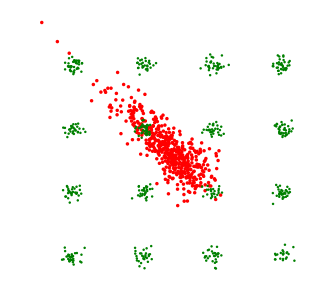

 10%|▉         | 3000/30001 [00:31<04:41, 95.80it/s]

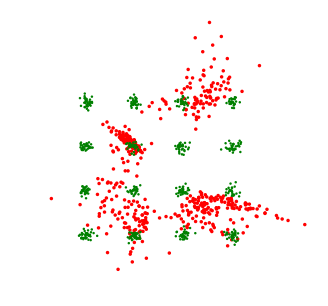

 20%|█▉        | 5992/30001 [01:02<04:09, 96.34it/s]

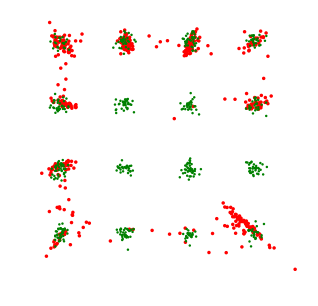

 30%|██▉       | 8995/30001 [01:33<03:37, 96.67it/s]

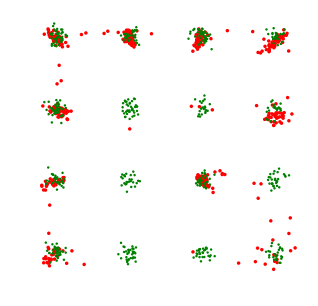

 40%|███▉      | 11997/30001 [02:03<03:06, 96.77it/s]

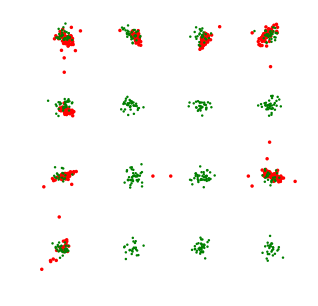

 50%|████▉     | 14993/30001 [02:35<02:35, 96.67it/s]

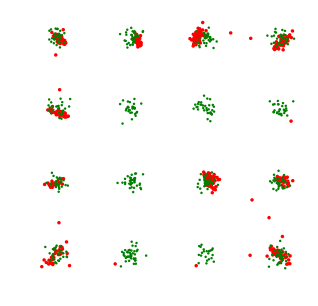

 60%|█████▉    | 17993/30001 [03:05<02:04, 96.75it/s]

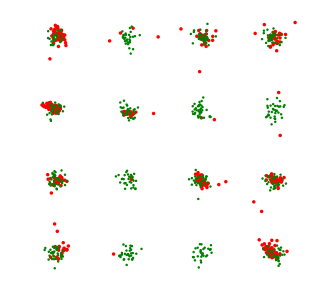

 70%|██████▉   | 20995/30001 [03:34<01:31, 97.89it/s]

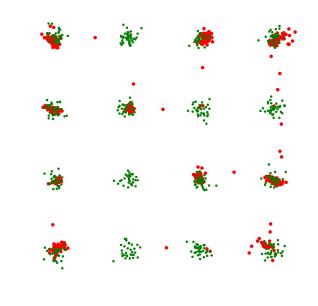

 80%|███████▉  | 23995/30001 [04:05<01:01, 97.76it/s]

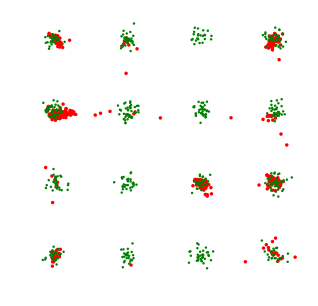

 90%|████████▉ | 26993/30001 [04:36<00:30, 97.73it/s]

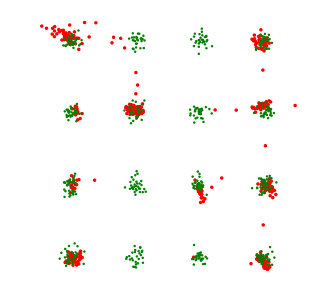

100%|█████████▉| 29991/30001 [05:07<00:00, 97.63it/s]

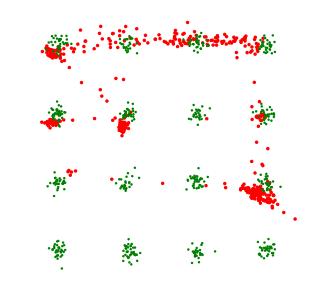

100%|██████████| 30001/30001 [05:07<00:00, 97.60it/s]


In [14]:
xmax = 3
fsd = []
fsg = []
frames = []
np_samples = []
n_batches_viz = 10
viz_every = params['viz_every']

nn_every = 200
y_ref = sess.run( data)
nn_dist = []
nn_kl =[]
for i in tqdm(range(params['max_iter']+1)):
#     fd,fg, _ = sess.run([loss_d,loss_g, training_op])
#     fsd.append(fd)
#     fsg.append(fg)
    sess.run(training_op)
#     sess.run(maintain_averages_op)
    
    if (i) % viz_every == 0:
        np_samples.append(np.vstack([sess.run(samples_ema) for _ in range(n_batches_viz)]))
#         print(np_samples[0].shape)
#         yy = sess.run(data)
#         xx = np_samples[0]

        xx, yy = sess.run([samples_ema, data])
        
        fig = figure(figsize=(5,5))
        scatter(xx[:, 0], xx[:, 1], edgecolor='none',s=12,c='r')
        scatter(yy[:, 0], yy[:, 1], c='g', edgecolor='none',s=6)
        axis('off')
        show()
        
#     if (i) % nn_every == 0:
#         x = np.vstack([sess.run(samples_ema) for _ in range(n_batches_viz)])
#         l2nn = nn_l2_mean(x,y_ref)
#         kl =estimate(x, y_ref,k=1)
#         nn_dist.append(l2nn)
#         nn_kl.append(kl)
# #         print('dist = ', l2nn)
# #         print('kl = ', kl)

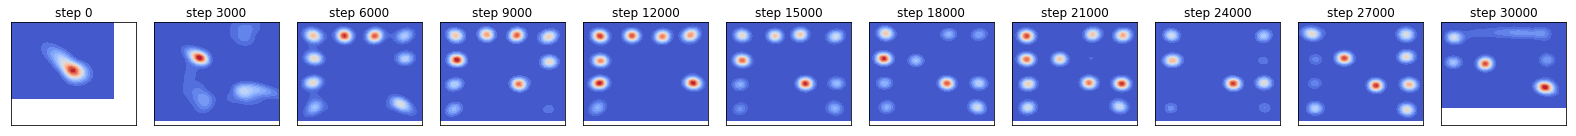

In [15]:
np_samples_ = np_samples[::1]
cols = len(np_samples_)
bg_color  = sns.color_palette('Greens', n_colors=256)[0]
figure(figsize=(2*cols, 2))
for i, samps in enumerate(np_samples_):
    if i == 0:
        ax = subplot(1,cols,1)
    else:
        subplot(1,cols,i+1, sharex=ax, sharey=ax)
    ax2 = sns.kdeplot(samps[:, 0], samps[:, 1], shade=True, cmap='coolwarm',bw=0.40, n_levels=20, clip=[[-6,6]]*2)
#     ax2.set_axis_bgcolor(bg_color)
    xticks([]); yticks([])
    title('step %d'%(i*viz_every))
gcf().tight_layout()

In [10]:
# plt.semilogy(nn_kl)
# plt.semilogy(nn_dist)
# plt.show()

In [11]:
# np.save('plot_ema_kl_4',nn_kl)
# np.save('plot_ema_nn_4',nn_dist)